In [1]:
### General ###
import os
import sys
import copy
from tqdm import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
import xgboost as xgb

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset_final.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission_final.csv')

In [3]:
train = train.drop(['매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis=1)

In [4]:
train.shape, test.shape, submission.shape

((23009, 30), (4244, 29), (4244, 2))

In [5]:
train.head(5)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,...,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9:00:00,13:00:00,...,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,10:00:00,16:00:00,...,1976-06-10,0,안드로이드,대중교통,천안/아산,1.0,1.0,1,0,0
2,T23790,2020-11-18,NaN,1,2020-11-23,10,6,2020-12-11,9:00:00,13:00:00,...,1970-04-05,0,안드로이드,대중교통,천안/아산,0.0,0.0,0,0,0
3,T18740,2020-11-09,NaN,1,2020-11-09,4,4,2020-11-30,9:00:00,14:00:00,...,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0
4,T08451,2020-02-25,NaN,1,2020-03-31,2,2,2020-04-07,9:00:00,13:00:00,...,1966-03-24,0,안드로이드,대중교통,천안/아산,0.0,0.0,1,0,1


In [6]:
submission.head()

,SEQ,pred
0,T54370,0.5
1,T47892,0.5
2,T56637,0.5
3,T45487,0.5
4,T41995,0.5


In [7]:
train['접수일'].min(), train['접수일'].max(), test['접수일'].min(), test['접수일'].max()

('2019-04-09', '2021-09-29', '2019-04-09', '2021-11-12')

In [8]:
train['장기서비스여부'].value_counts(), test['장기서비스여부'].value_counts()

(1    20726
 0     2283
 Name: 장기서비스여부, dtype: int64,
 1    3666
 0     578
 Name: 장기서비스여부, dtype: int64)

In [9]:
train['기존고객여부'].value_counts(), test['기존고객여부'].value_counts()

(1    20084
 0     2925
 Name: 기존고객여부, dtype: int64,
 1    3643
 0     601
 Name: 기존고객여부, dtype: int64)

In [10]:
train['결재형태'].value_counts(), test['결재형태'].value_counts()

(신용카드     15428
 무통장입금     5961
 가상계좌      1609
 미수          11
 Name: 결재형태, dtype: int64,
 신용카드     2904
 무통장입금    1014
 가상계좌      320
 Name: 결재형태, dtype: int64)

In [11]:
train['주거형태'].value_counts(), test['주거형태'].value_counts()

(일반주택       19655
 오피스텔/원룸     3354
 Name: 주거형태, dtype: int64,
 일반주택       3304
 오피스텔/원룸     940
 Name: 주거형태, dtype: int64)

In [12]:
train['평수'].value_counts(), test['평수'].value_counts()

(40평대이상    5831
 30평대      5357
 20평대      1772
 10평대       896
 Name: 평수, dtype: int64,
 30평대      1153
 40평대이상     958
 20평대       446
 10평대       389
 Name: 평수, dtype: int64)

In [13]:
train['매니저성별'].value_counts(), test['매니저성별'].value_counts()

(0    23009
 Name: 매니저성별, dtype: int64,
 0    4243
 1       1
 Name: 매니저성별, dtype: int64)

In [14]:
train['매니저사용휴대폰'].value_counts(), test['매니저사용휴대폰'].value_counts()

(안드로이드    17971
 기타        1705
 ios        534
 Name: 매니저사용휴대폰, dtype: int64,
 안드로이드    3429
 기타        300
 ios        85
 Name: 매니저사용휴대폰, dtype: int64)

In [15]:
train['매니저이동방법'].value_counts(), test['매니저이동방법'].value_counts()

(대중교통    17249
 자차       5510
 Name: 매니저이동방법, dtype: int64,
 대중교통    3245
 자차       927
 Name: 매니저이동방법, dtype: int64)

In [16]:
train['근무가능지역'].value_counts(), test['근무가능지역'].value_counts()

(천안/아산    14332
 기타        2352
 서울        2154
 원주/춘천     2137
 부산         824
 광주         714
 수도권        286
 평택         210
 Name: 근무가능지역, dtype: int64,
 천안/아산    2307
 서울        610
 원주/춘천     487
 기타        444
 광주        144
 부산        107
 수도권        93
 평택         52
 Name: 근무가능지역, dtype: int64)

In [17]:
train['CS교육이수여부'].value_counts(), test['CS교육이수여부'].value_counts()

(0.0    16450
 1.0     3760
 Name: CS교육이수여부, dtype: int64,
 0.0    2922
 1.0     893
 Name: CS교육이수여부, dtype: int64)

In [18]:
train['청소교육이수여부'].value_counts(), test['청소교육이수여부'].value_counts()

(0.0    15897
 1.0     4313
 Name: 청소교육이수여부, dtype: int64,
 0.0    2822
 1.0     993
 Name: 청소교육이수여부, dtype: int64)

In [19]:
train['부재중서비스가능여부'].value_counts(), test['부재중서비스가능여부'].value_counts()

(1    19081
 0     3928
 Name: 부재중서비스가능여부, dtype: int64,
 1    3618
 0     626
 Name: 부재중서비스가능여부, dtype: int64)

In [20]:
train['추천인여부'].value_counts(), test['추천인여부'].value_counts()

(0    22848
 1      161
 Name: 추천인여부, dtype: int64,
 0    4189
 1      55
 Name: 추천인여부, dtype: int64)

## 기본 전처리 및 feature 생성

In [58]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일']).dt.year

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S').dt.hour
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S').dt.hour

train['서비스소요시간'] = train['서비스종료시간'] - train['서비스시작시간']
train['회차사용비율'] = train['현재회차'] / train['전체회차']

# 기간 관련 피처
#train['접수일기준_고객가입기간'] = train['접수일'] - train['고객가입일']
train['접수후최초서비스걸린시일'] = train['최초서비스일'] - train['접수일']
train['접수후서비스걸린시일'] = train['서비스일자'] - train['접수일']
train['최초서비스_서비스_시일'] = train['서비스일자'] - train['최초서비스일']

AttributeError: Can only use .dt accessor with datetimelike values

In [22]:
# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
#test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S').dt.hour
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S').dt.hour

test['서비스소요시간'] = test['서비스종료시간'] - test['서비스시작시간']
test['회차사용비율'] = test['현재회차'] / test['전체회차']

# 기간 관련 피처
#test['접수일기준_고객가입기간'] = test['접수일'] - test['고객가입일']
test['접수후최초서비스걸린시일'] = test['최초서비스일'] - test['접수일']
test['접수후서비스걸린시일'] = test['서비스일자'] - test['접수일']
test['최초서비스_서비스_시일'] = test['서비스일자'] - test['최초서비스일']

In [23]:
# timedelta 형식 feature -> int형식으로
#train['접수일기준_고객가입기간'] = train['접수일기준_고객가입기간'].dt.days.astype('int16')
train['접수후최초서비스걸린시일'] = train['접수후최초서비스걸린시일'].dt.days.astype('int16')
train['접수후서비스걸린시일'] = train['접수후서비스걸린시일'].dt.days.astype('int16')
train['최초서비스_서비스_시일'] = train['최초서비스_서비스_시일'].dt.days.astype('int16')
train['서비스소요시간'] = train['서비스소요시간'].dt.seconds.astype('int32') // 3600

#test['접수일기준_고객가입기간'] = test['접수일기준_고객가입기간'].dt.days.astype('int16')
test['접수후최초서비스걸린시일'] = test['접수후최초서비스걸린시일'].dt.days.astype('int16')
test['접수후서비스걸린시일'] = test['접수후서비스걸린시일'].dt.days.astype('int16')
test['최초서비스_서비스_시일'] = test['최초서비스_서비스_시일'].dt.days.astype('int16')
test['서비스소요시간'] = test['서비스소요시간'].dt.seconds.astype('int32') // 3600

In [24]:
# 시간 추가 여부
train['시간추가여부'] = train['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)
test['시간추가여부'] = test['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)

In [25]:
train['시간비율'] = train['서비스시작시간'] / train['서비스종료시간']
test['시간비율'] = test['서비스시작시간'] / test['서비스종료시간']

In [26]:
# sin, cos encoding 월/주/일까지 적용
#train['sin_서비스시작시간'] = np.sin(2*np.pi*train['서비스시작시간2']/24)
#train['cos_서비스시작시간'] = np.cos(2*np.pi*train['서비스시작시간2']/24)
#train['sin_서비스종료시간'] = np.sin(2*np.pi*train['서비스종료시간2']/24)
#train['cos_서비스종료시간'] = np.cos(2*np.pi*train['서비스종료시간2']/24)

#test['sin_서비스시작시간'] = np.sin(2*np.pi*test['서비스시작시간2']/24)
#test['cos_서비스시작시간'] = np.cos(2*np.pi*test['서비스시작시간2']/24)
#test['sin_서비스종료시간'] = np.sin(2*np.pi*test['서비스종료시간2']/24)
#test['cos_서비스종료시간'] = np.cos(2*np.pi*test['서비스종료시간2']/24)

In [27]:
# 매니저 나이
train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x)

In [28]:
#고객 열만~ 
na_sum = []
for i in range (0, train.shape[0], 1):
    na_all = train.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum.append(na_all)

In [29]:
na_sum_te = []
for i in range (0, test.shape[0], 1):
    na_all = test.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum_te.append(na_all)

In [30]:
na_df = pd.DataFrame(na_sum)
na_df.columns = ['na값']

In [31]:
na_df_te = pd.DataFrame(na_sum_te)
na_df_te.columns = ['na값']

In [32]:
train = pd.concat([train, na_df], axis=1)
test = pd.concat([test, na_df_te], axis=1)

In [33]:
train.head()

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,...,서비스종료시간2,서비스소요시간,회차사용비율,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,시간비율,매니저나이,na값
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,1900-01-01 09:00:00,1900-01-01 13:00:00,...,13,4,1.00,6,20,14,0,0.692308,65,4
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,1900-01-01 10:00:00,1900-01-01 16:00:00,...,16,6,0.75,3,39,36,0,0.625000,45,3
2,T23790,2020-11-18,NaN,1,2020-11-23,10,6,2020-12-11,1900-01-01 09:00:00,1900-01-01 13:00:00,...,13,4,0.60,5,23,18,0,0.692308,51,1
3,T18740,2020-11-09,NaN,1,2020-11-09,4,4,2020-11-30,1900-01-01 09:00:00,1900-01-01 14:00:00,...,14,5,1.00,0,21,21,1,0.642857,65,0
4,T08451,2020-02-25,NaN,1,2020-03-31,2,2,2020-04-07,1900-01-01 09:00:00,1900-01-01 13:00:00,...,13,4,1.00,35,42,7,0,0.692308,55,4


## 데이터 셋 세팅

In [34]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저성별', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '매칭성공여부', '서비스시작시간2', '서비스종료시간2', '서비스소요시간', '회차사용비율', '접수후최초서비스걸린시일',
       '접수후서비스걸린시일', '최초서비스_서비스_시일', '시간추가여부', '시간비율', '매니저나이', 'na값'],
      dtype='object')

In [35]:
features = ['장기서비스여부', '전체회차', '현재회차', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', 
            '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 
            'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스시작시간2', 
            '서비스종료시간2', '서비스소요시간', '회차사용비율', '접수후최초서비스걸린시일', '접수후서비스걸린시일', 
            '최초서비스_서비스_시일', '시간추가여부', '매니저나이', 'na값', '시간비율']

In [36]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

## 결측치 처리

In [39]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물']#, '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [40]:
# train, test셋의 구성이 다른 피처 처리 - 결제형태, 서비스주소
ftr['서비스주소'] = ftr.서비스주소.str[:2]
ftr['결재형태'] = ftr.결재형태.replace('미수', np.NaN) # or 드랍 
                               
ftr_te['서비스주소'] = ftr_te.서비스주소.str[:2]
ftr_te['결재형태'] = ftr_te.결재형태.replace('미수', np.NaN) # or 드랍 

In [41]:
# 한글로 구성되어 있는 피처 Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['주거형태', '평수', '우선청소', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', '서비스주소', '결재형태', 
       'CS교육이수여부', '청소교육이수여부']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [42]:
ftr['평수'] = ftr.평수.replace(4, np.NaN)
ftr['우선청소'] = ftr.우선청소.replace(5, np.NaN)
ftr['매니저사용휴대폰'] = ftr.매니저사용휴대폰.replace(3, np.NaN)
ftr['매니저이동방법'] = ftr.매니저이동방법.replace(2, np.NaN)
ftr['CS교육이수여부'] = ftr.CS교육이수여부.replace(2, np.NaN)
ftr['청소교육이수여부'] = ftr.청소교육이수여부.replace(2, np.NaN)

### train, test셋의 구성이 다른 피처 처리 - 반려동물

In [43]:
print(set(train['결재형태'].unique()) - set(test['결재형태'].unique()))
print(set(test['결재형태'].unique()) - set(train['결재형태'].unique()))

{'미수'}
{nan}


In [44]:
# 앞에 두글자만 따던지 해야할듯
print(set(train['서비스주소'].unique()) - set(test['서비스주소'].unique()))
print(set(test['서비스주소'].unique()) - set(train['서비스주소'].unique()))

{'부산 동래구', '경남 창원시'}
{'부산 부산진구', '서울 송파구', '서울 광진구', '부산 사상구', '부산 금정구', '부산 북구', '경기 화성시'}


In [45]:
# 원핫으로 나눠서 체크해야할듯
print(set(train['반려동물'].unique()) - set(test['반려동물'].unique()))
print(set(test['반려동물'].unique()) - set(train['반려동물'].unique()))

set()
{'고양이,기타', '개,기타', '개,고양이'}


In [46]:
train['반려동물'].unique(), test['반려동물'].unique()

(array([nan, '없음', '기타', '고양이', '개'], dtype=object),
 array(['개', '없음', '기타', '개,고양이', '고양이', nan, '고양이,기타', '개,기타'],
       dtype=object))

#### 반려동물

In [47]:
ftr['반려동물_고양이'] = 0
ftr['반려동물_개'] = 0
ftr['반려동물_기타'] = 0
ftr['반려동물_없음'] = 0

ftr_te['반려동물_고양이'] = 0
ftr_te['반려동물_개'] = 0
ftr_te['반려동물_기타'] = 0
ftr_te['반려동물_없음'] = 0

In [48]:
for i in range(ftr.shape[0]):
    # 한가지 종류 키우는 집
    if ftr['반려동물'][i] == '개':
        ftr['반려동물_개'][i] += 1
    elif ftr['반려동물'][i] == '고양이':
        ftr['반려동물_고양이'][i] += 1
    elif ftr['반려동물'][i] == '기타':
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '없음':
        ftr['반려동물_없음'][i] += 1
    
    # 두가지 종류 키우는 집
    elif ftr['반려동물'][i] == '개,고양이':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
    elif ftr['반려동물'][i] == '고양이,개':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
    elif ftr['반려동물'][i] == '고양이,기타':
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '개,기타':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_기타'][i] += 1
        
    # 세가지 종류 키우는 집
    elif ftr['반려동물'][i] == '개,기타,고양이':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '개,고양이,기타':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '고양이,기타,개':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '고양이,개,기타':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
        
    else:
        continue

In [49]:
for i in range(ftr_te.shape[0]):
    # 한가지 종류 키우는 집
    if ftr_te['반려동물'][i] == '개':
        ftr_te['반려동물_개'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이':
        ftr_te['반려동물_고양이'][i] += 1
    elif ftr_te['반려동물'][i] == '기타':
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '없음':
        ftr_te['반려동물_없음'][i] += 1
    
    # 두가지 종류 키우는 집
    elif ftr_te['반려동물'][i] == '개,고양이':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,개':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,기타':
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '개,기타':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
        
    # 세가지 종류 키우는 집
    elif ftr_te['반려동물'][i] == '개,기타,고양이':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '개,고양이,기타':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,기타,개':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,개,기타':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
        
    else:
        continue

In [50]:
ftr = ftr.drop('반려동물', axis=1)
ftr_te = ftr_te.drop('반려동물', axis=1)

In [51]:
ftr.shape, ftr_te.shape, target.shape

((23009, 33), (4244, 33), (23009,))

In [52]:
ftr.columns

Index(['장기서비스여부', '전체회차', '현재회차', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수',
       '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부',
       '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스시작시간2', '서비스종료시간2', '서비스소요시간',
       '회차사용비율', '접수후최초서비스걸린시일', '접수후서비스걸린시일', '최초서비스_서비스_시일', '시간추가여부',
       '매니저나이', 'na값', '시간비율', '반려동물_고양이', '반려동물_개', '반려동물_기타', '반려동물_없음'],
      dtype='object')

In [53]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '부재중여부', '우선청소', 
                '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', 
                '부재중서비스가능여부', '추천인여부', '시간추가여부', '반려동물_고양이', '반려동물_개', '반려동물_기타', 
                '반려동물_없음']

In [54]:
cat_lst = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 28, 29, 30, 31]

In [55]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2


In [56]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

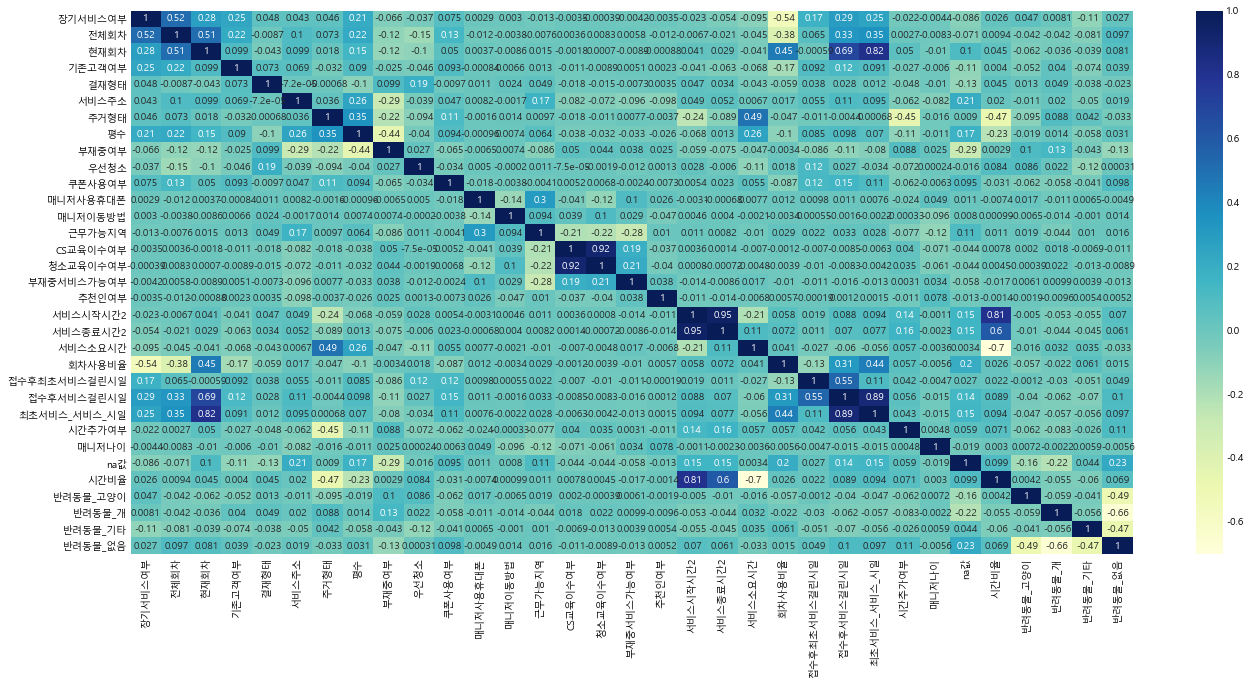

In [57]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 스케일링

In [224]:
num_features = list(set(ftr.columns) - set(cat_features))

In [225]:
num_features

['접수후서비스걸린시일',
 '서비스시작시간2',
 '최초서비스_서비스_시일',
 '서비스종료시간2',
 'na값',
 '접수후최초서비스걸린시일',
 '매니저나이',
 '전체회차',
 '회차사용비율',
 '현재회차',
 '서비스소요시간']

### Min-max

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

### Gauss rank
* https://github.com/aldente0630/gauss_rank_scaler

In [226]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [227]:
scaler = GaussRankScaler()
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

In [228]:
ftr_imputed.head()

,장기서비스여부,전체회차,현재회차,기존고객여부,결재형태,서비스주소,주거형태,평수,부재중여부,우선청소,...,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,매니저나이,na값,반려동물_고양이,반려동물_개,반려동물_기타,반려동물_없음
0,1.0,-0.594939,-0.540560,1.0,1.0,6.0,1.0,3.0,0.0,4.0,...,-0.547017,-0.433881,-0.456364,0.0,0.956422,2.751064,0.0,0.0,0.0,1.0
1,1.0,-0.370644,-0.540560,1.0,1.0,6.0,1.0,3.0,0.0,1.0,...,-0.743857,-0.029707,0.269150,0.0,-0.323588,0.304797,0.0,0.0,0.0,1.0
2,1.0,0.906758,0.098979,1.0,2.0,6.0,1.0,3.0,0.0,1.0,...,-0.607350,-0.363807,-0.304408,0.0,0.000177,-0.304408,0.0,0.0,0.0,1.0
3,1.0,-0.370644,-0.304408,1.0,1.0,5.0,1.0,2.0,0.0,1.0,...,-1.026835,-0.410081,-0.199393,1.0,0.956422,-2.751064,0.0,0.0,0.0,1.0
4,1.0,-0.905952,-0.862895,1.0,1.0,6.0,1.0,2.0,0.0,4.0,...,0.607863,0.030062,-0.797507,0.0,0.211849,2.751064,0.0,0.0,0.0,1.0


## 차원축소

In [89]:
ftr.columns

Index(['장기서비스여부', '전체회차', '현재회차', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역',
       'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스시작시간2', '서비스종료시간2',
       '서비스소요시간', '회차사용비율', '접수후최초서비스걸린시일', '접수후서비스걸린시일', '최초서비스_서비스_시일',
       '시간추가여부', '매니저나이', 'na값'],
      dtype='object')

## Embedding

### fasttext

In [229]:
ftr_imputed['서비스특징'] = ftr_imputed['결재형태'].astype(str) + '_' + ftr_imputed['서비스주소'].astype(str) + '_' + ftr_imputed['주거형태'].astype(str) + '_' + ftr_imputed['평수'].astype(str) + '_' \
+ ftr_imputed['우선청소'].astype(str) + '_' + ftr_imputed['매니저사용휴대폰'].astype(str) + '_' +  ftr_imputed['매니저이동방법'].astype(str) + '_' \
+ ftr_imputed['근무가능지역'].astype(str)

ftr_te_imputed['서비스특징'] = ftr_te_imputed['결재형태'].astype(str) + '_' + ftr_te_imputed['서비스주소'].astype(str) + '_' + ftr_te_imputed['주거형태'].astype(str) + '_' + ftr_te_imputed['평수'].astype(str) + '_' \
+ ftr_te_imputed['우선청소'].astype(str) + '_' + ftr_te_imputed['매니저사용휴대폰'].astype(str) + '_' +  ftr_te_imputed['매니저이동방법'].astype(str) + '_' \
+ ftr_te_imputed['근무가능지역'].astype(str)

In [230]:
import random

train_data = list(ftr_imputed['서비스특징'].unique())
test_data = list(ftr_te_imputed['서비스특징'].unique())

In [231]:
test_data[0]

'2.0_6.0_1.0_3.0_3.0_2.0_0.0_5.0'

In [232]:
from gensim.models.fasttext import FastText

In [233]:
model = FastText(sentences=train_data, size=30, window=5, min_count=1, sg=1)

In [234]:
model.train(sentences=train_data, epochs=5, total_examples=model.corpus_count, 
            total_words=model.corpus_total_words)

In [235]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████████| 1802/1802 [00:00<00:00, 10206.43it/s]


In [236]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████████| 1177/1177 [00:00<00:00, 10536.99it/s]


In [237]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.columns = train_mean_vector.columns.astype(str) + "_service"

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.columns = test_mean_vector.columns.astype(str) + "_service"

In [238]:
train_mean_vector['서비스특징'] = train_data
test_mean_vector['서비스특징'] = test_data

In [239]:
ftr_imputed = ftr_imputed.merge(train_mean_vector, on='서비스특징', how='left').drop('서비스특징', axis=1)
ftr_te_imputed = ftr_te_imputed.merge(test_mean_vector, on='서비스특징', how='left').drop('서비스특징', axis=1)

In [240]:
ftr_imputed.shape, ftr_te_imputed.shape

((23009, 62), (4244, 62))

## 샘플링(아마 안하는게 좋지 않을까 싶음)

### over sampling

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
# SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(ftr_imputed, target)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', ftr_imputed.shape, target.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (23009, 30) (23009,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (41622, 30) (41622,)
SMOTE 적용 후 레이블 값 분포: 
 0    20811
1    20811
Name: 매칭성공여부, dtype: int64


In [79]:
ftr_imputed = X_train_over
target = y_train_over

In [34]:
# 문제는 특이 치에있을 수 있습니다. 앞서 언급했듯이 ADASYN은 밀도가 낮은 밀도 데이터에 중점을 둡니다. 
# 종종 저밀도 데이터는 특이 치입니다. 그런 다음 ADASYN 접근 방식은 피쳐 공간의 이러한 영역에 너무 많은주의를 기울여 
# 모델 성능을 저하시킬 수 있습니다. ADASYN을 사용하기 전에 이상 값을 제거하는 것이 좋습니다.
from imblearn.over_sampling import *
X_samp, y_samp = ADASYN(random_state=0, sampling_strategy='minority').fit_sample(ftr_imputed, target)

In [35]:
X_samp.shape, y_samp.shape

((41204, 30), (41204,))

### combine sampling

## 모델링

In [241]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [242]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [243]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '부재중여부', '우선청소', 
                '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', 
                '부재중서비스가능여부', '추천인여부', '시간추가여부', '반려동물_고양이', '반려동물_개', '반려동물_기타', 
                '반려동물_없음']

In [244]:
ftr_imputed.shape, target.shape, ftr_te_imputed.shape

((23009, 62), (23009,), (4244, 62))

### Catboost

In [245]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [246]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [247]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [248]:
cb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='AUC', class_weights=class_weights,
                        silent=True, loss_function='Logloss')
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict_proba(val_x, ntree_end=best)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = cb.predict_proba(ftr_te_imputed, ntree_end=best)[:, 1] / 5
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

0:	test: 0.6042285	best: 0.6042285 (0)	total: 186ms	remaining: 31m 4s
2000:	test: 0.9177478	best: 0.9177478 (2000)	total: 1m 15s	remaining: 5m
4000:	test: 0.9313502	best: 0.9314580 (3968)	total: 2m 46s	remaining: 4m 9s
6000:	test: 0.9347821	best: 0.9348576 (5889)	total: 4m 21s	remaining: 2m 54s
8000:	test: 0.9366430	best: 0.9367771 (7962)	total: 5m 51s	remaining: 1m 27s
9999:	test: 0.9374731	best: 0.9374868 (9997)	total: 7m 26s	remaining: 0us

bestTest = 0.9374867651
bestIteration = 9997

Shrink model to first 9998 iterations.
FOLD ROC-AUC = 0.9374856707615686
0:	test: 0.5889831	best: 0.5889831 (0)	total: 40.5ms	remaining: 6m 45s
2000:	test: 0.9220777	best: 0.9221263 (1994)	total: 1m 40s	remaining: 6m 39s
4000:	test: 0.9345493	best: 0.9345974 (3982)	total: 3m 41s	remaining: 5m 31s
6000:	test: 0.9370208	best: 0.9370208 (6000)	total: 5m 44s	remaining: 3m 49s
8000:	test: 0.9386628	best: 0.9386902 (7993)	total: 8m 5s	remaining: 2m 1s
Stopped by overfitting detector  (1000 iterations wait)


In [249]:
cb_pred.shape

(4244,)

In [250]:
cb_pred

array([1.08591243e-04, 3.70874803e-01, 1.49390176e-01, ...,
       4.19946496e-01, 1.48550645e-03, 6.00762643e-01])

### TabNet

In [101]:
ftr[cat_features] = ftr[cat_features].astype(str)
ftr_te[cat_features] = ftr_te[cat_features].astype(str)

In [102]:
if "Set" not in ftr.columns:
    ftr["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(ftr.shape[0],))

train_indices = ftr[ftr.Set=="train"].index
valid_indices = ftr[ftr.Set=="valid"].index
test_indices = ftr[ftr.Set=="test"].index

In [103]:
import os
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [104]:
nunique = ftr.nunique()
types = ftr.dtypes

categorical_columns = []
categorical_dims =  {}
for col in ftr.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, ftr[col].nunique())
        l_enc = LabelEncoder()
        ftr[col] = ftr[col].fillna("VV_likely")
        ftr[col] = l_enc.fit_transform(ftr[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        ftr.fillna(ftr.loc[train_indices, col].mean(), inplace=True)

장기서비스여부 2
전체회차 11
현재회차 10
기존고객여부 2
결재형태 4
서비스주소 42
주거형태 2
평수 5
부재중여부 3
우선청소 6
쿠폰사용여부 2
매니저사용휴대폰 4
매니저이동방법 3
근무가능지역 8
CS교육이수여부 3
청소교육이수여부 3
부재중서비스가능여부 2
추천인여부 2
서비스시작시간2 12
서비스종료시간2 14
서비스소요시간 7
회차사용비율 33
접수후최초서비스걸린시일 42
접수후서비스걸린시일 90
최초서비스_서비스_시일 55
시간추가여부 2
매니저나이 35
na값 4
반려동물_고양이 2
반려동물_개 2
반려동물_기타 2
반려동물_없음 2
Set 3


In [106]:
# Contains dimension and idxs of categorical variable for categorical embedding.
unused_feat = ['Set']
features = [ col for col in ftr.columns if col not in unused_feat] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [107]:
from tqdm import tqdm
features = ftr_te.columns.tolist()
len(features)

for col in tqdm(features):
    ftr_te[col+'_bin'] = ftr_te[col].apply(lambda x: 1 if np.cbrt(x)>0 else 0)

print(f"test_df: {ftr_te.shape}")
ftr_te.head(20)

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]


TypeError: ufunc 'cbrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [108]:
nunique = ftr_te.nunique()
types = ftr_te.dtypes

categorical_columns = []
categorical_dims =  {}
for col in ftr_te.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, ftr_te[col].nunique())
        l_enc = LabelEncoder()
        ftr_te[col] = ftr_te[col].fillna("VV_likely")
        ftr_te[col] = l_enc.fit_transform(ftr_te[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        ftr_te.fillna(ftr_te.loc[test_indices, col].mean(), inplace=True)

장기서비스여부 2
전체회차 11
현재회차 10
기존고객여부 2
결재형태 4
서비스주소 47
주거형태 2
평수 5
부재중여부 3
우선청소 6
쿠폰사용여부 2
매니저사용휴대폰 4
매니저이동방법 3
근무가능지역 8
CS교육이수여부 3
청소교육이수여부 3
부재중서비스가능여부 2
추천인여부 2
서비스시작시간2 11
서비스종료시간2 11
서비스소요시간 7
회차사용비율 33
접수후최초서비스걸린시일 42
접수후서비스걸린시일 88
최초서비스_서비스_시일 54
시간추가여부 2
매니저나이 35
na값 5
반려동물_고양이 2
반려동물_개 2
반려동물_기타 2
반려동물_없음 2


In [109]:
# Contains dimension and idxs of categorical variable for categorical embedding.
unused_feat = ['Set']
features = [ col for col in ftr_te.columns if col not in unused_feat] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [110]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

Device used : cuda


In [125]:
X_train = ftr.iloc[train_indices].reset_index(drop=True)
X_valid = ftr.iloc[valid_indices].reset_index(drop=True)
y_train = target[train_indices].reset_index(drop=True)
y_valid = target[valid_indices].reset_index(drop=True)

In [126]:
X_train

,장기서비스여부,전체회차,현재회차,기존고객여부,결재형태,서비스주소,주거형태,평수,부재중여부,우선청소,쿠폰사용여부,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,서비스시작시간2,서비스종료시간2,서비스소요시간,회차사용비율,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,매니저나이,na값,반려동물_고양이,반려동물_개,반려동물_기타,반려동물_없음,Set
0,1,2,2,1,1,41,1,4,2,0,0,3,1,3,0,0,1,0,3,4,2,32,9,24,14,0,31,3,0,0,0,0,1
1,1,3,2,1,1,41,1,4,2,0,0,3,1,6,1,1,1,0,4,7,4,24,6,43,35,0,11,2,0,0,0,1,1
2,1,9,5,1,3,41,1,3,0,0,0,3,1,6,0,0,0,0,3,4,2,19,8,27,18,0,17,1,0,0,0,1,1
3,1,3,3,1,1,21,1,2,0,2,0,3,1,3,0,0,1,0,3,5,3,32,3,25,21,1,31,0,0,0,0,1,1
4,1,7,5,1,1,40,1,4,2,0,0,3,2,6,0,0,1,0,3,4,2,24,17,53,34,0,21,2,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18467,1,4,3,1,0,41,1,3,0,0,0,3,1,2,0,0,1,0,2,4,3,26,18,40,21,1,8,1,0,0,0,1,1
18468,1,3,0,1,3,0,0,1,1,1,0,3,2,6,0,0,1,0,10,9,0,8,4,5,0,0,17,0,1,0,0,0,1
18469,1,9,8,1,3,40,1,4,2,0,1,3,1,6,0,0,1,0,8,9,2,31,30,89,54,0,18,2,0,0,0,1,1
18470,1,3,2,1,3,40,1,4,2,0,0,3,2,6,1,1,1,0,8,9,2,24,5,20,14,0,20,3,0,0,0,0,1


In [128]:
max_epochs = 100

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

KeyError: 1658

In [123]:
prediction = clf.predict(X_test)

NameError: name 'X_test' is not defined

## submission

In [251]:
submission['pred'] = cb_pred

In [252]:
#submission['pred'] = submission['pred'].apply(lambda x : 1 if x >= 0.5 else 0)

In [253]:
#submission['pred'].value_counts()

In [254]:
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T54370,0.000109
T47892,0.370875
T56637,0.149390
T45487,0.007280
T41995,0.011978
...,...
T31589,0.067979
T36236,0.001207
T34729,0.419946


In [255]:
submission.to_csv('submission/1119_cat_gr_ft_5fold_pyeong.csv')